<a href="https://colab.research.google.com/github/jpcpereira/pdeng__tutorial_deep_learning/blob/master/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Deep Learning - Practical Session
# **Fraud Detection**



<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1g0eXpZ8CPj0UlpLxhip0NI5DsaJj9oDl#scrollTo=IzhAWHoGXhTv"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/jpcpereira/pdeng__tutorial_deep_learning/blob/master/fraud_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://www.kaggle.com/mlg-ulb/creditcardfraud">Dataset Source</a>
  </td>  
</table>

## Import Libraries

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

plt.style.use('ggplot')
import seaborn as sns
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


## Load Fraud Dataset 

In [0]:
# Download file
csv_path = tf.keras.utils.get_file(
    origin='http://dl.dropboxusercontent.com/s/ao21z1j9m1ijclq/creditcard.zip?dl=0',
    fname='creditcard.zip', extract=True)
csv_path

66363392/66359665 [==============================] - 1s 0us/step


'/root/.keras/datasets/creditcard.zip'

In [0]:
# Read dataset
df = pd.read_csv(csv_path)

In [0]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Class Distribution (Imbalanced Dataset)

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Activity')]

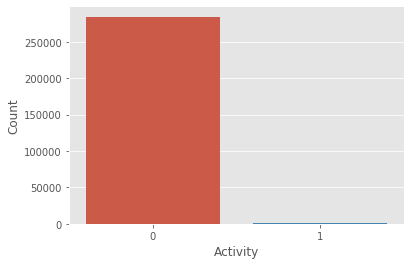

In [0]:
ax = sns.countplot(x="Class", data=df)
ax.set(xlabel='Activity', ylabel='Count')

In [0]:
print("Class Distribution    ", "Fraud: ",(df.Class==1).sum()/df.shape[0]*100, "Not Fraud: ",(df.Class==0).sum()/df.shape[0]*100)
print("Class Count    ", "Fraud: ",(df.Class==1).sum(), "samples", "Not Fraud: ",(df.Class==0).sum(), "samples")

Class Distribution     Fraud:  0.1727485630620034 Not Fraud:  99.82725143693798
Class Count     Fraud:  492 samples Not Fraud:  284315 samples


## Split Dataset

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1], df.iloc[:, -1], test_size=0.2)

## Data Normalization

In [0]:
from sklearn.preprocessing import RobustScaler

scale_columns = df.columns[0:-2]
scaler = RobustScaler()

scaler = scaler.fit(x_train)

x_train = scaler.transform(x_train.to_numpy())
x_test = scaler.transform(x_test.to_numpy())

## Build Model
Three ways of defining models in TensorFlow Keras:

*   Sequential API
*   Functional API
*   Subclassing API




In [0]:
INPUT_DIM = x_train.shape[1] # Dimension of each data point (denoted x)
CODE_DIM = 2 # Dimension of the latent space/code/bottleneck of the autoencoder (denoted z)

In [0]:
# Sequential API

model = tf.keras.Sequential([
    tf.keras.layers.Dense(CODE_DIM, 
                          batch_input_shape=(None, INPUT_DIM), 
                          activation="tanh", 
                          activity_regularizer=tf.keras.regularizers.l1(10e-5)),
    tf.keras.layers.Dense(INPUT_DIM, activation='relu')
])

In [0]:
# Functional API

x = tf.keras.layers.Input(shape=(INPUT_DIM,))
z = tf.keras.layers.Dense(CODE_DIM, 
                          batch_input_shape=(None, INPUT_DIM), 
                          activation="tanh", 
                          activity_regularizer=tf.keras.regularizers.l1(10e-5))(x)
reconstructed_x = tf.keras.layers.Dense(INPUT_DIM, activation='relu')(z)

# Define models
model = tf.keras.models.Model(inputs=x, outputs=reconstructed_x)
encoder_z = tf.keras.models.Model(inputs=x, outputs=z)

In [0]:
model.compile(loss='mse', optimizer='Adam') # Configure model for training
model.summary() # Check model architecture

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 62        
_________________________________________________________________
dense_3 (Dense)              (None, 30)                90        
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________


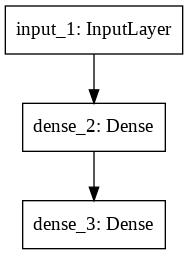

In [0]:
# Plot model
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

## Model Training

In [0]:
NUM_EPOCHS = 10 # Number of training epochs
BATCH_SIZE = 32 # Size of a mini-batch used for gradient update

In [0]:
history = model.fit(
    x_train, x_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, x_test),
    shuffle=True
)

Train on 227845 samples, validate on 56962 samples
Epoch 1/10
227845/227845 [==============================] - 20s 88us/sample - loss: 1.7626 - val_loss: 1.9377
Epoch 2/10
227845/227845 [==============================] - 18s 80us/sample - loss: 1.6290 - val_loss: 1.8502
Epoch 3/10
227845/227845 [==============================] - 18s 81us/sample - loss: 1.5786 - val_loss: 1.8076
Epoch 4/10
227845/227845 [==============================] - 18s 80us/sample - loss: 1.5523 - val_loss: 1.7790
Epoch 5/10
227845/227845 [==============================] - 18s 80us/sample - loss: 1.5367 - val_loss: 1.7658
Epoch 6/10
227845/227845 [==============================] - 18s 80us/sample - loss: 1.5260 - val_loss: 1.7474
Epoch 7/10
227845/227845 [==============================] - 18s 81us/sample - loss: 1.5188 - val_loss: 1.7366
Epoch 8/10
227845/227845 [==============================] - 18s 81us/sample - loss: 1.5135 - val_loss: 1.7288
Epoch 9/10
227845/227845 [==============================] - 18s 79us/

## Save Model

In [0]:
filepath = "model"
tf.keras.models.save_model(
    model,
    filepath,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


## Learning Curves

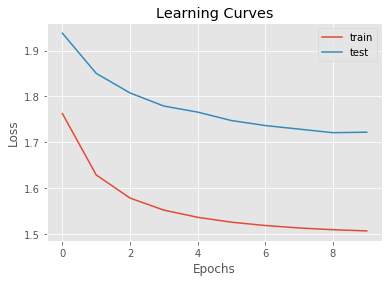

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Learning Curves"); plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.legend();

## Predict On Test Set

In [0]:
predictions = model.predict(x_test)

# Compute reconstruction error
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})

## Model Evaluation

In [0]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

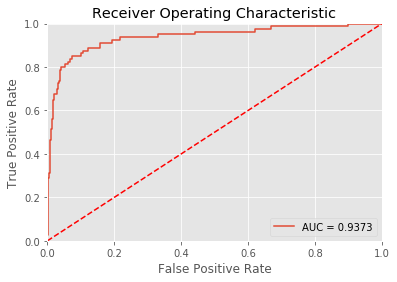

In [0]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--'); plt.xlim([-0.001, 1]); plt.ylim([0, 1.001])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate');

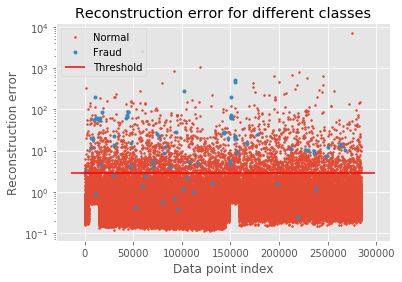

In [0]:
threshold = 2.9
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', 
            ms=3 if name == 1 else 1.5, linestyle='',
            label="Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.yscale('log')
plt.title("Reconstruction error for different classes")
plt.xlabel("Data point index"); plt.ylabel("Reconstruction error");

## Confusion Matrix

In [0]:
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
print(conf_matrix)

[[53811  3071]
 [   15    65]]


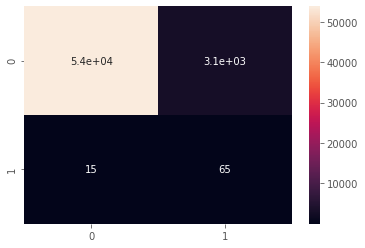

In [0]:
sns.heatmap(conf_matrix, annot=True)

## Latent Space

In [0]:
z_test = encoder_z.predict(x_test) # Predict code z given input x

NameError: ignored

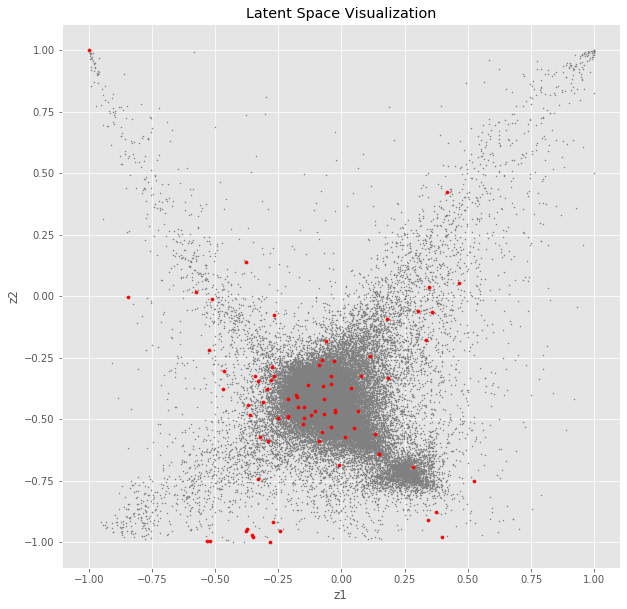

In [0]:
plt.figure(figsize=(10, 10))
plt.scatter(z_test[np.where(y_test==0)[0],0], z_test[np.where(y_test==0)[0],1], s=1.0, color="grey")
plt.scatter(z_test[np.where(y_test==1)[0],0], z_test[np.where(y_test==1)[0],1], s=10.0, color="red")
plt.title("Latent Space Visualization")
plt.xlabel(r"z1"); plt.ylabel(r"z2");